In [1]:
!pip install git+https://github.com/lonanni/WaterNets

  Cloning https://github.com/lonanni/WaterNets to /tmp/pip-req-build-vpp22fln
  Running command git clone --filter=blob:none --quiet https://github.com/lonanni/WaterNets /tmp/pip-req-build-vpp22fln
  Resolved https://github.com/lonanni/WaterNets to commit 0c593272957f4dea80dc1850dbadf552615a3ba0
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TinyMLDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1CTqSzBrCYC0m9cNgwEZtlymQ-3SMJG99/TinyMLDrive


In [3]:
#This loads in the training data from the googledrive folder and returns the training data arrays
def load_data(path):
    X = []
    y = []

    for file in glob.glob(path+'/*.npz'):
        data = np.load(file)
        X.extend(data['X'])
        y.extend(data['y'])
    return np.array(X), np.array(y)

#This scales the image colours so that it looks nice
def scale_im(reader):
    red = reader.read(3)
    green = reader.read(2)
    blue = reader.read(1)
    scale = lambda x : (x*0.0000275) - 0.2
    return np.dstack([scale(red), scale(green), scale(blue)]) * 3

In [4]:
#This is just a simple normalising class
class SimpleScaler:
    def fit(self, X):
        self.min = np.min(X)
        self.max = np.max(X)

    def transform(self, X):
        return (X - self.min) / (self.max - self.min)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

#This is a more complex normalising funciton which discards the extreme values
#to scale the depth map nicer
def robust_normalize(arr):
    # Calculate the median and median absolute deviation (MAD)
    median = np.median(arr)
    mad = np.median(np.abs(arr - median))

    # Calculate the modified z-score for each element
    z_scores = 0.6745 * (arr - median) / mad

    # Set a threshold for outliers (e.g., z-score greater than 3.5)
    threshold = 3.5

    # Replace outliers with the median value
    normalized_arr = np.where(np.abs(z_scores) > threshold, median, arr)

    # Normalize the array using the maximum absolute value
    max_abs_value = np.max(np.abs(normalized_arr))
    normalized_arr /= max_abs_value

    return normalized_arr

In [6]:
import glob
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
import numpy as np

In [11]:
from imblearn.under_sampling import RandomUnderSampler


In [13]:
from sklearn.model_selection import train_test_split


In [14]:
X_water, y_water = load_data("/content/drive/MyDrive/TinyMLDrive/water_mask_data/training")
X_water = X_water.reshape(-1, X_water.shape[-1])
y_water = y_water.flatten()
X_under_water, y_under_water = RandomUnderSampler().fit_resample(X_water, y_water)

y_under_water = tf.keras.utils.to_categorical(y_under_water.astype(np.int32))

scale_water = SimpleScaler()

X_scaled_water = scale_water.fit_transform(X_under_water)

X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(X_scaled_water, y_under_water, test_size=0.2)

In [15]:
# Defining the networl layers and nodes
WaterNet = tf.keras.Sequential([
    layers.Input(shape=X_train_water.shape[1:]), # 6, as the filters
    layers.Dense(10, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# Compiling the network and assigning the metrics to assess the models performance on
WaterNet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy', 'AUC']
)

# Training the network to predict water or not water
WaterNet.fit(
    X_train_water,
    y_train_water,
    epochs=10,
    batch_size=2048,
    validation_split=0.2,
)

# Saving the network to the google drive
WaterNet.save("/content/drive/MyDrive/TinyML/WaterNetBase.h5")

Epoch 1/10
462/462 [==============================] - 5s 8ms/step - loss: 0.4288 - accuracy: 0.9155 - auc: 0.9727 - val_loss: 0.2081 - val_accuracy: 0.9721 - val_auc: 0.9940
Epoch 2/10
462/462 [==============================] - 3s 5ms/step - loss: 0.1544 - accuracy: 0.9738 - auc: 0.9939 - val_loss: 0.1207 - val_accuracy: 0.9762 - val_auc: 0.9952
Epoch 3/10
462/462 [==============================] - 2s 4ms/step - loss: 0.1042 - accuracy: 0.9775 - auc: 0.9952 - val_loss: 0.0906 - val_accuracy: 0.9798 - val_auc: 0.9959
Epoch 4/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0816 - accuracy: 0.9807 - auc: 0.9958 - val_loss: 0.0735 - val_accuracy: 0.9823 - val_auc: 0.9962
Epoch 5/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0684 - accuracy: 0.9834 - auc: 0.9963 - val_loss: 0.0633 - val_accuracy: 0.9843 - val_auc: 0.9965
Epoch 6/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0604 - accuracy: 0.9850 - auc: 0.9966 - val_loss: 0.05

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import os

In [18]:
WaterNetSize = os.path.getsize("/content/drive/MyDrive/TinyML/WaterNetBase.h5")
print(f"WaterNet: {WaterNetSize/1000} kB")

WaterNet: 44.296 kB


In [21]:
import rasterio

In [23]:
# path for the images
file_path = '/content/drive/MyDrive/TinyML/Satellite/WaterNets/Portsmouth'
file_path_raw = os.path.join(file_path,os.path.join(file_path,'RAW/2021-07-01'),os.listdir(os.path.join(file_path,'RAW/2021-07-01'))[0])
file_path_sr = os.path.join(file_path,os.path.join(file_path,'SR/2021-07-01'),os.listdir(os.path.join(file_path,'SR/2021-07-01'))[0])
print(file_path_raw)
#open the images
raw_image = rasterio.open(file_path_raw)
sr_image = scale_im(rasterio.open(file_path_sr))
#define the current shape of the image (they are flatten in the spatial dimension to train the NN)
image_shape = raw_image.read(1).shape
# stack the images in the different filters
test_image = np.dstack([raw_image.read(1),raw_image.read(2),raw_image.read(3),raw_image.read(4),raw_image.read(5),raw_image.read(6)])
#reshape them to not longer be flatten
test_image = test_image.reshape(np.product(image_shape), 6)
#apply the scaler
test_image_water = scale_water.transform(test_image)
#resize the images
test_image_water = test_image_water.reshape((image_shape[0], image_shape[1], 6))

/content/drive/MyDrive/TinyML/Satellite/WaterNets/Portsmouth/RAW/2021-07-01/LC08_202025_20210714.tif


In [26]:
import matplotlib.pyplot as plt

In [33]:
import matplotlib

In [29]:
#inference with WaterNet on test image
water_mask_unrolled = WaterNet(test_image_water.reshape((np.product(image_shape), 6)))
water_mask = np.array(water_mask_unrolled)[:, 1].reshape((image_shape[0], image_shape[1])) > 0.8


In [42]:
mask_cmap = matplotlib.colors.ListedColormap(['forestgreen', 'darkblue'])


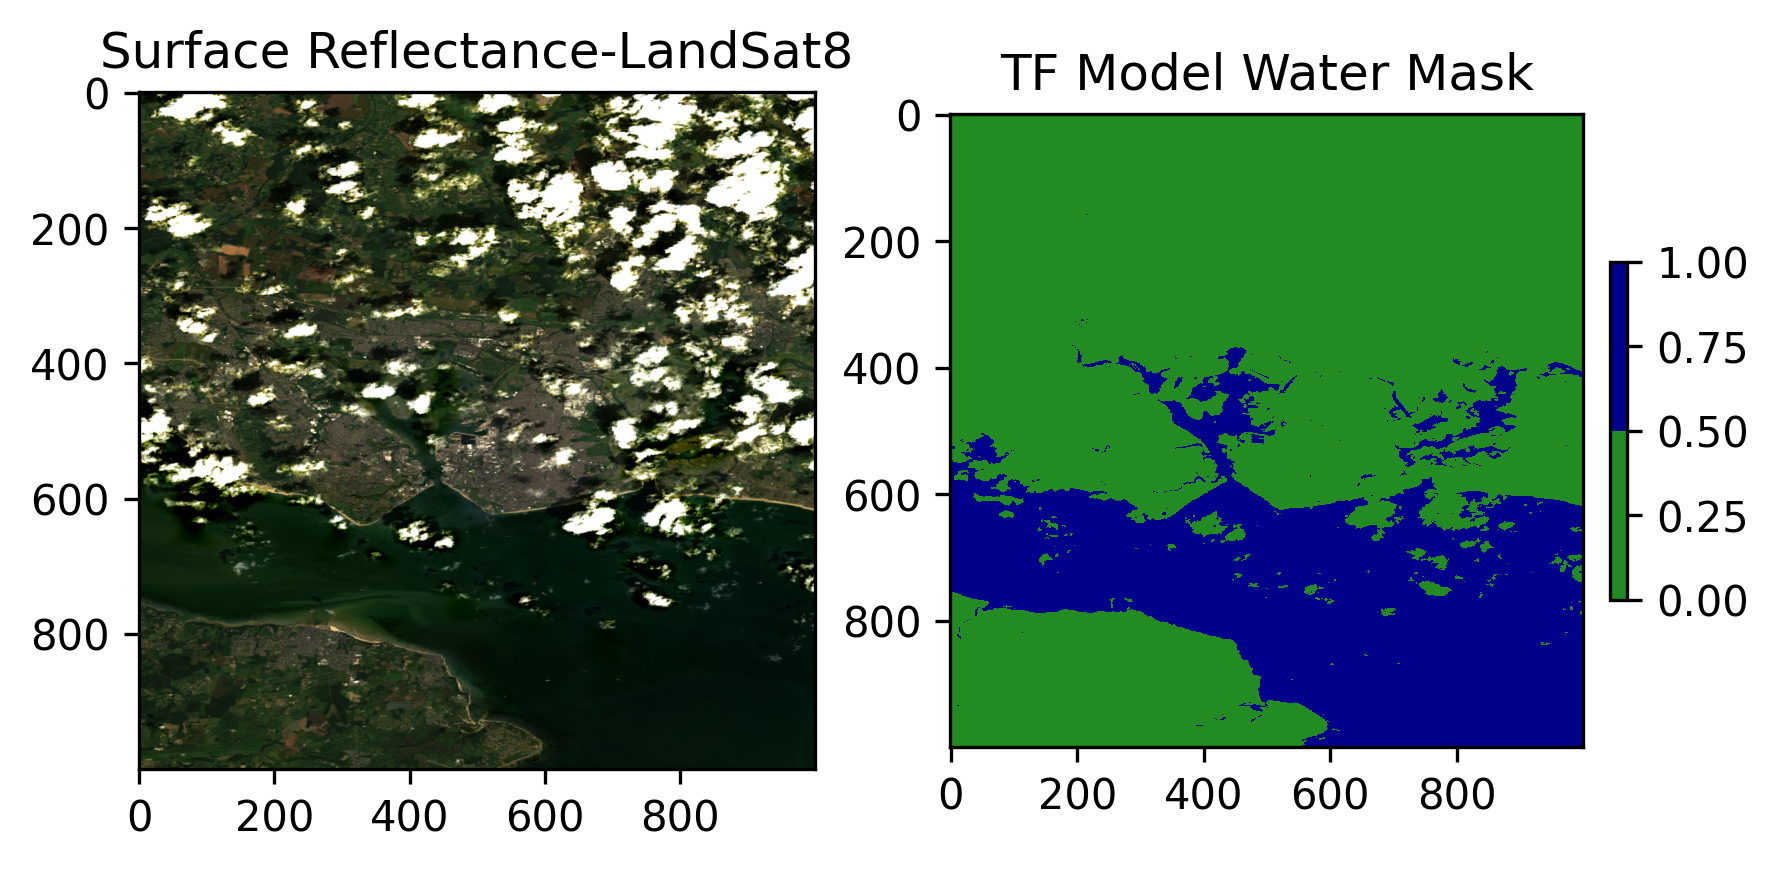

In [45]:
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(sr_image)
ax[0].title.set_text('Surface Reflectance-LandSat8')


ax[1].imshow(sr_image)
ax[1].title.set_text('TF Model Water Mask')
cmap = plt.get_cmap('Reds_r')
d = ax[1].imshow(water_mask, cmap=mask_cmap, alpha=1)
plt.colorbar(d, fraction=0.025, pad=0.04)
plt.show()